<a href="https://colab.research.google.com/github/Caroline-511/Brain_tumor_detection_using_Machine-learning_and_Image-processing-/blob/main/Small_datasets_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
from keras.utils import np_utils
from keras.models import Sequential
from tensorflow import keras

In [ ]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
        # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image


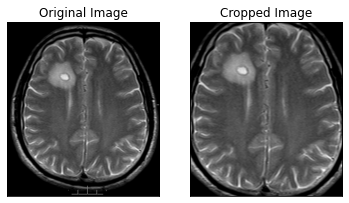

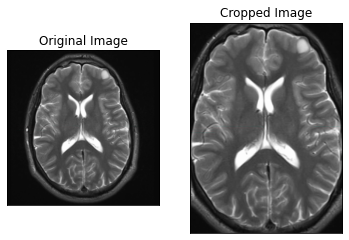

In [ ]:
ex_img = cv2.imread('/content/gdrive/My Drive/project/yes/Y3.jpg')
ex_new_img = crop_brain_contour(ex_img, True)
ex_img1 = cv2.imread('/content/gdrive/My Drive/project/no/No15.jpg')
ex_new_img1 = crop_brain_contour(ex_img1, True)

In [ ]:
def load_data(dir_list, image_size):
    
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory+'//'+ filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    return X, y


In [ ]:
augmented_path = '/content/gdrive/My Drive/project/new_data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2064
X shape is: (2064, 240, 240, 3)
y shape is: (2064, 1)


In [ ]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

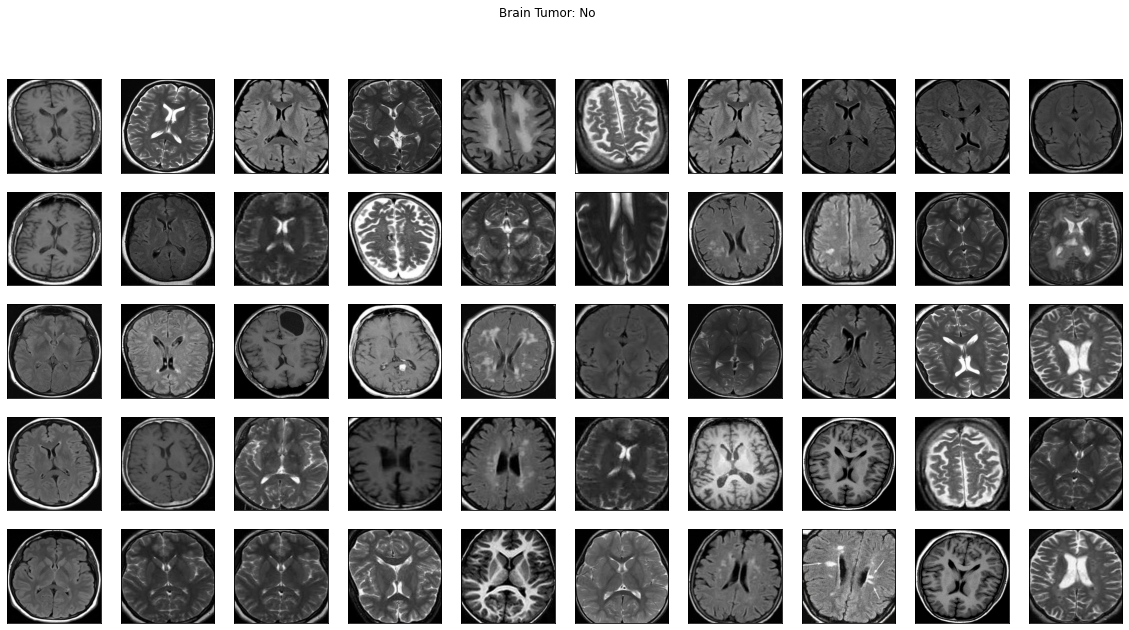

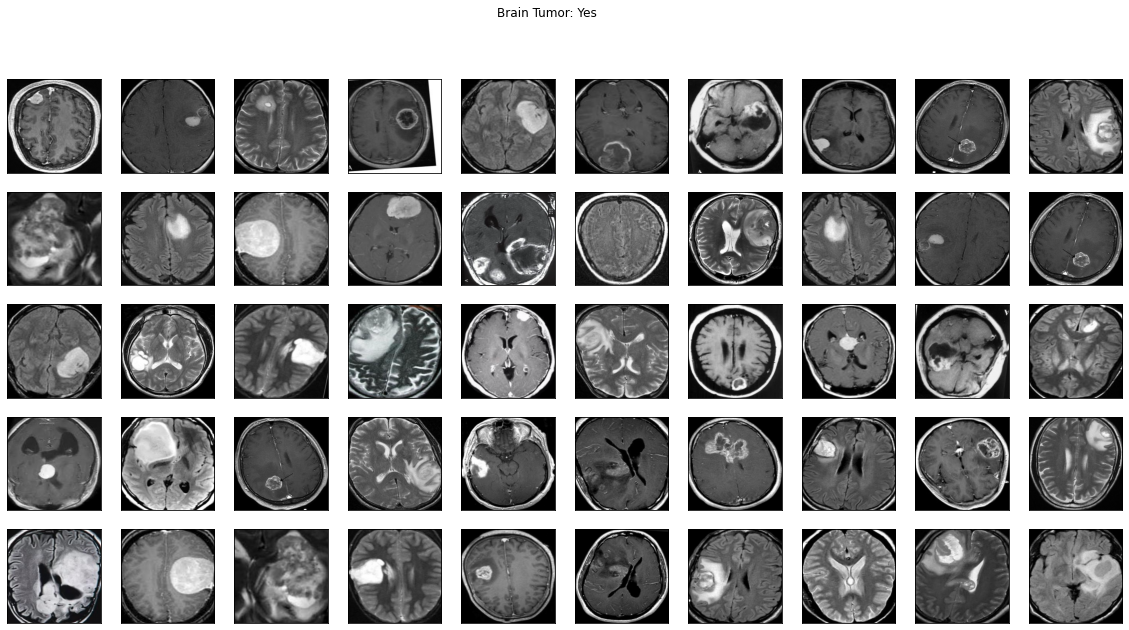

In [ ]:
plot_sample_images(X, y)


In [ ]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)


In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1444
number of development examples = 310
number of test examples = 310
X_train shape: (1444, 240, 240, 3)
Y_train shape: (1444, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


# AlexNet Model

In [ ]:
#alexnet model

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(240,240,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 58, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 58, 58, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])

In [ ]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'/content/gdrive/My Drive/project/logs_alexnet/{log_file_name}')

In [ ]:
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("/content/gdrive/My Drive/project/models_alexnet/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=1, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
1444/1444 [==============================] - 404s 280ms/step - loss: 0.8514 - accuracy: 0.8470 - val_loss: 2.8609 - val_accuracy: 0.6548
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/project/models_alexnet/cnn-parameters-improvement-01-0.65.model/assets
Epoch 2/10
1444/1444 [==============================] - 404s 280ms/step - loss: 0.3378 - accuracy: 0.9183 - val_loss: 6.1007 - val_accuracy: 0.6226
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/project/models_alexnet/cnn-parameters-improvement-02-0.62.model/assets
Epoch 3/10
1444/1444 [==============================] - 405s 280ms/step - loss: 0.2919 - accuracy: 0.9335 - val_loss: 4.1422 - val_accuracy: 0.6387
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/project/models_alexnet/cnn-parameters-improvement-03-0.64.model/assets
Epoch 4/10
1444/1444 [==============================] - 403s 279ms/step - loss: 0.1397 - accuracy: 0.9633 - val_loss: 3.3872 - val_accuracy: 0.6484
INFO:tensorflow

In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=1, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
1444/1444 [==============================] - 406s 281ms/step - loss: 0.0245 - accuracy: 0.9910 - val_loss: 7.2988 - val_accuracy: 0.6548
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/project/models_alexnet/cnn-parameters-improvement-01-0.65.model/assets
Epoch 2/3
1444/1444 [==============================] - 407s 282ms/step - loss: 0.0616 - accuracy: 0.9841 - val_loss: 7.2610 - val_accuracy: 0.6419
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/project/models_alexnet/cnn-parameters-improvement-02-0.64.model/assets
Epoch 3/3
1444/1444 [==============================] - 407s 282ms/step - loss: 0.0404 - accuracy: 0.9896 - val_loss: 6.2639 - val_accuracy: 0.6581
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/project/models_alexnet/cnn-parameters-improvement-03-0.66.model/assets
Elapsed time: 0:20:34.4


In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=1, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
1444/1444 [==============================] - 408s 282ms/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 7.0665 - val_accuracy: 0.6419
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/project/models_alexnet/cnn-parameters-improvement-01-0.64.model/assets
Epoch 2/3
1444/1444 [==============================] - 405s 280ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 8.2245 - val_accuracy: 0.6516
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/project/models_alexnet/cnn-parameters-improvement-02-0.65.model/assets
Epoch 3/3
1444/1444 [==============================] - 404s 280ms/step - loss: 0.0154 - accuracy: 0.9958 - val_loss: 7.0360 - val_accuracy: 0.6387
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/project/models_alexnet/cnn-parameters-improvement-03-0.64.model/assets
Elapsed time: 0:20:29.5


In [ ]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=1, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
1444/1444 [==============================] - 410s 284ms/step - loss: 9.2114e-04 - accuracy: 1.0000 - val_loss: 7.3483 - val_accuracy: 0.6548
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/project/models_alexnet/cnn-parameters-improvement-01-0.65.model/assets
Epoch 2/3
1444/1444 [==============================] - 411s 285ms/step - loss: 0.0120 - accuracy: 0.9945 - val_loss: 7.6335 - val_accuracy: 0.6419
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/project/models_alexnet/cnn-parameters-improvement-02-0.64.model/assets
Epoch 3/3
1444/1444 [==============================] - 410s 284ms/step - loss: 0.0104 - accuracy: 0.9972 - val_loss: 8.4276 - val_accuracy: 0.6484
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/project/models_alexnet/cnn-parameters-improvement-03-0.65.model/assets
Elapsed time: 0:20:44.0


In [ ]:
history = model.history.history

In [ ]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

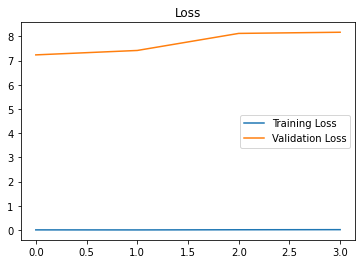

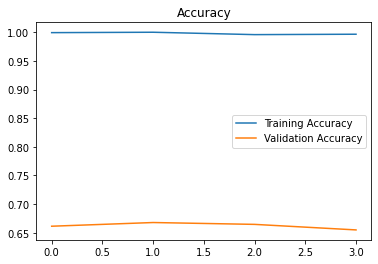

In [ ]:
plot_metrics(history)

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model(filepath='/content/gdrive/My Drive/project/models_alexnet/cnn-parameters-improvement-08-0.67.model')

In [ ]:
best_model = load_model(filepath='/content/gdrive/My Drive/project/models_alexnet/cnn-parameters-improvement-08-0.67.model')

In [ ]:
best_model.metrics_names

['loss', 'accuracy']

In [ ]:
loss, acc = best_model.evaluate(x=X_test,y=y_test)

10/10 [==============================] - 11s 1s/step - loss: 5.0350 - accuracy: 0.6903


In [ ]:
print (f"Test Accuracy = {acc}")

Test Accuracy = 0.6903225779533386


# New Section

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
